# Bitmap Matching

This notebook explores the use of curvature to get an signal for potential anchoring points for aligning to pieces together. Once the pieces are aligned, the quality of the match is determined by computing the overlap in pixels. The less overlap and tighter coverage of the space - the better the match. The notebook also explores the use of neighboring pixel colors to augment the signal indicating how good the match is.

In [29]:
import json
import os
from matplotlib import pyplot
import numpy as np

import piece

In [18]:
DATA_DIR = '../data/unicorn/'

with open(os.path.join(DATA_DIR, 'locations.json')) as f:
    truth = json.loads(f.read())
print(truth)

[[61, 44, 59, 78, 60, 21, 42, 41, 43, 13, 6], [62, 53, 46, 39, 12, 22, 54, 4, 31, 79, 9], [84, 24, 56, 45, 64, 14, 18, 8, 93, 48, 33], [37, 80, 40, 67, 72, 2, 90, 29, 66, 28, 27], [88, 25, 57, 70, 84, 19, 47, 73, 77, 30, 86, 75], [36, 98, 96, 85, 23, 63, 87, 95, 68, 74, 5], [3, 97, 49, 26, 16, 76, 92, 17, 81, 89, 32], [71, 38, 94, 69, 35, 55, 65, 82, 99, 20, 52], [58, 91, 1, 7, 50, 10, 11, 51, 15, 0, 83]]


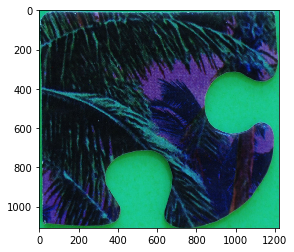

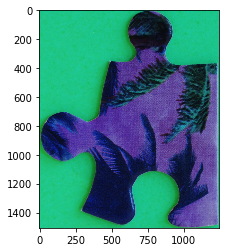

In [46]:
p1 = piece.read_piece(os.path.join(DATA_DIR, '61.jpg'))
p2 = piece.read_piece(os.path.join(DATA_DIR, '44.jpg'))
pyplot.figure()
pyplot.imshow(p1.image)
pyplot.figure()
pyplot.imshow(p2.image)

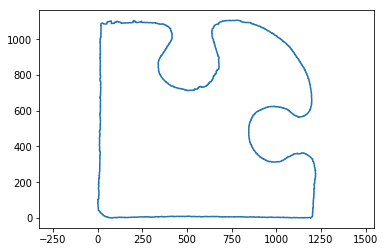

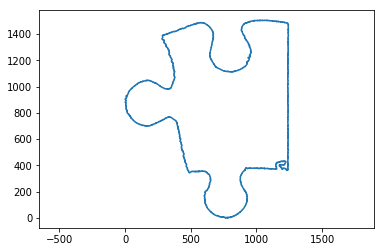

In [47]:
def plot_contour(contour):
    pyplot.plot(contour[:, 0], contour[:, 1])
    pyplot.axis('equal')
    
pyplot.figure()
plot_contour(p1.contour)
pyplot.figure()
plot_contour(p2.contour)

### Figure out the mechanics of FFT in NumPy

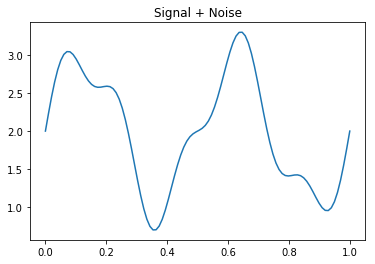

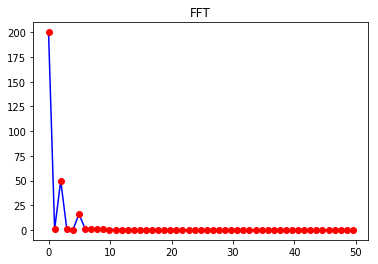

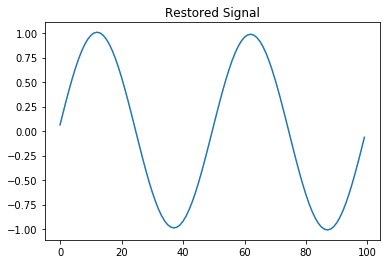

In [171]:
t = np.linspace(0, 1, 100) # one millisecond sampling
signal = np.sin(t * 4 * np.pi)
noise = np.sin(t * 10 * np.pi) / 3
bias = 2
total = signal + noise + bias

pyplot.figure()
pyplot.title('Signal + Noise')
pyplot.plot(t, total)

f = np.fft.rfft(total)
timestep = t[1] - t[0] # assuming window is one second.
fx = np.fft.rfftfreq(n=total.size, d=timestep)

pyplot.figure()
pyplot.title('FFT')
pyplot.plot(fx, np.abs(f), 'b')
pyplot.plot(fx, np.abs(f), 'ro')

f[3:] = 0
f[0] = 0
restored = np.fft.irfft(f)
pyplot.figure()
pyplot.title('Restored Signal')
pyplot.plot(restored)


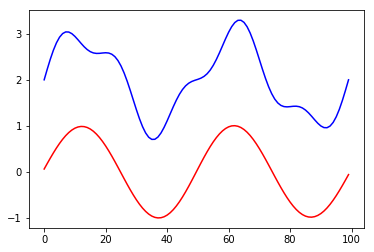

In [176]:
def smooth(signal, cutoff, d=1):
    f = np.fft.rfft(signal)
    fx = np.fft.rfftfreq(n=signal.size, d=d)
    f[fx > cutoff] = 0
    return np.fft.irfft(f)

t = np.linspace(0, 1, 100) # one millisecond sampling
signal = np.sin(t * 4 * np.pi)
noise = np.sin(t * 10 * np.pi) / 3
bias = 2
total = signal + noise + bias

restored = smooth(signal, d=t[1] - t[0], cutoff=3)
pyplot.plot(total, 'b')
pyplot.plot(restored, 'r')

#### Idea: smoothing a contour in polar coordiantes
Another apporach to smoothing out a contour would be to convert the gradient to polar coordinates and remove the high frequencies from the angular component of the gradient.

### Investigate the frequencies of the curvature signal

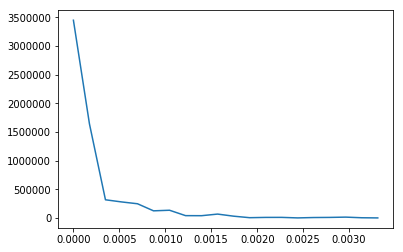

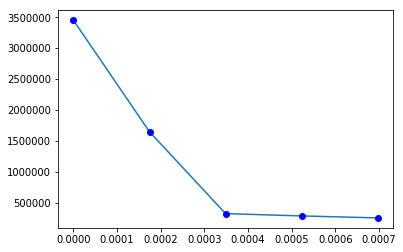

In [189]:
c = p1.contour[:, 0]
f = np.fft.rfft(c)
fx = np.fft.rfftfreq(n=c.size)
pyplot.figure()
pyplot.plot(fx[:20], np.abs(f)[:20])
pyplot.figure()
pyplot.plot(fx[:5], np.abs(f)[:5])
pyplot.plot(fx[:5], np.abs(f)[:5], 'bo')

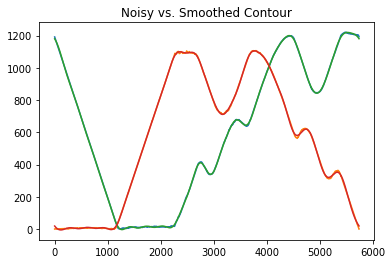

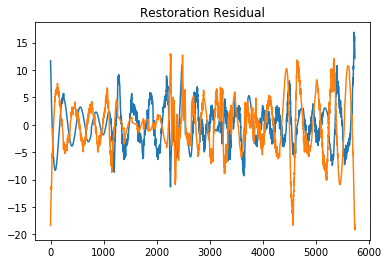

In [251]:
def smooth_contour(c, cutoff):
    c1 = c[:, 0]
    c2 = c[:, 1]
    c1f = smooth(c1, cutoff)
    c2f = smooth(c2, cutoff)
    return np.vstack([c1f, c2f]).T
    

c = p1.contour
pyplot.figure()
pyplot.title('Noisy vs. Smoothed Contour')
pyplot.plot(c)
cf = smooth_contour(c, cutoff=3e-3)
pyplot.plot(cf)

pyplot.figure()
pyplot.title('Restoration Residual')
pyplot.plot(c - cf)

## Curvature

Text(0.5,1,'Curvature')

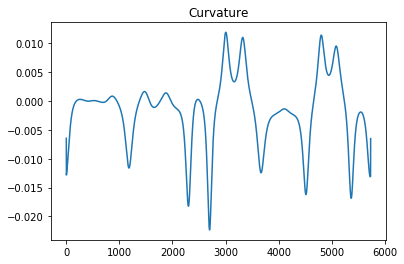

In [292]:
def curvature(contour):
    x = contour[:, 0]
    y = contour[:, 1]
    xp = np.gradient(x)
    yp = np.gradient(y)
    xpp = np.gradient(xp)
    ypp = np.gradient(yp)
    return (xp * ypp - yp * xpp) / np.power(xp**2 + yp**2, 3 / 2)
    
c = smooth_contour(p1.contour, cutoff=2.5e-3)
k = curvature(c)
pyplot.plot(k)
pyplot.title('Curvature')

#### Find Zero Crossings

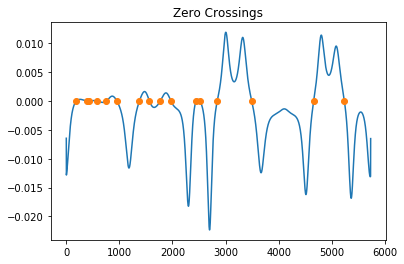

In [336]:
c = smooth_contour(p1.contour, cutoff=2.5e-3)
k = curvature(c)
# spikes = np.gradient(np.sign(np.gradient(k)))
zeros = np.where(np.diff(np.sign(k)))[0]

pyplot.figure()
pyplot.title('Zero Crossings')
pyplot.plot(k)
pyplot.plot(zeros, k[zeros], 'o')


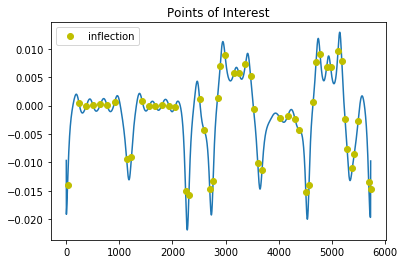

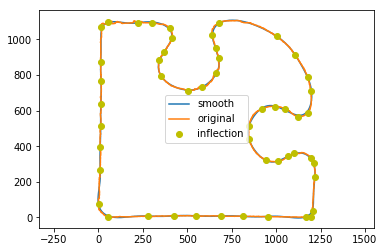

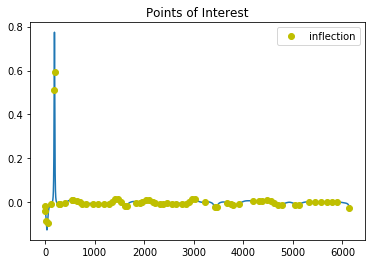

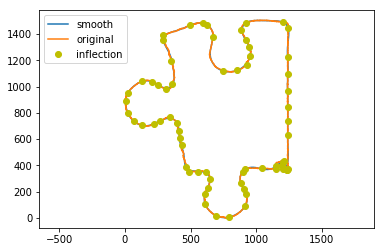

In [344]:
def zero_crossings(x):
    return np.where(np.diff(np.sign(x)))[0]

def plot_contour_points_of_interest(c, cutoff=4e-3):
    cs = smooth_contour(c, cutoff=cutoff)
    k = curvature(cs)
    z = zero_crossings(k)
    cr = zero_crossings(np.gradient(k))
    inf = zero_crossings(np.gradient(np.gradient(k)))

    pyplot.figure()
    pyplot.title('Points of Interest')
    pyplot.plot(k)
#     pyplot.plot(z, k[z], 'ro', label='zeros')
#     pyplot.plot(cr, k[cr], 'go', label='critical')
    pyplot.plot(inf, k[inf], 'yo', label='inflection')
    pyplot.legend()

    pyplot.figure()
    pyplot.plot(cs[:, 0], cs[:, 1], label='smooth')
    pyplot.plot(c[:, 0], c[:, 1], label='original')
#     pyplot.plot(c[z, 0], c[z, 1], 'ro', label='zeros')
#     pyplot.plot(c[cr, 0], c[cr, 1], 'go', label='critical')
    pyplot.plot(c[inf, 0], c[inf, 1], 'yo', label='inflection')
    pyplot.legend()
    pyplot.axis('equal')


plot_contour_points_of_interest(p1.contour)
plot_contour_points_of_interest(p2.contour)